<a href="https://colab.research.google.com/github/95ImadEL/Tensorflow-basics/blob/main/Fine_tuning_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2023-01-23 12:16:51--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-23 12:16:51 (99.6 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [10]:
unzip_data("Weather_dataset.zip")

In [11]:
walk_through_dir("Weather_dataset")

There are 2 directories and 0 images in 'Weather_dataset'.
There are 4 directories and 0 images in 'Weather_dataset/test'.
There are 0 directories and 60 images in 'Weather_dataset/test/cloudy'.
There are 0 directories and 43 images in 'Weather_dataset/test/rain'.
There are 0 directories and 50 images in 'Weather_dataset/test/shine'.
There are 0 directories and 71 images in 'Weather_dataset/test/sunrise'.
There are 4 directories and 0 images in 'Weather_dataset/train'.
There are 0 directories and 240 images in 'Weather_dataset/train/cloudy'.
There are 0 directories and 172 images in 'Weather_dataset/train/rain'.
There are 0 directories and 203 images in 'Weather_dataset/train/shine'.
There are 0 directories and 286 images in 'Weather_dataset/train/sunrise'.


In [12]:
train_dir = "Weather_dataset/train/"
test_dir = "Weather_dataset/test/"

In [13]:
import tensorflow as tf

IMG_SIZE = (224,224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="categorical",
                                                                 batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="categorical",
                                                                 batch_size=32)

Found 901 files belonging to 4 classes.
Found 224 files belonging to 4 classes.


In [58]:
class_names = train_data.class_names

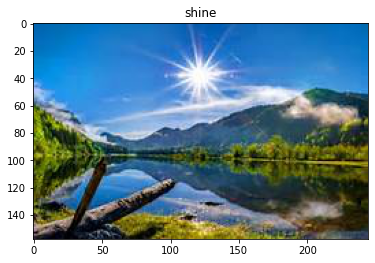

In [31]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

def visualize_random_img(dataset_dir):
  random_dir = random.choice(os.listdir(dataset_dir))
  random_class = random.choice(os.listdir(dataset_dir+random_dir))
  random_image = random.choice(os.listdir(dataset_dir+random_dir+"/"+random_class))
  img = mpimg.imread(dataset_dir+random_dir+"/"+random_class+"/"+random_image)
  plt.imshow(img)
  plt.title(random_class)

visualize_random_img("Weather_dataset/")

In [33]:
checkpoint_filepath = 'weather_checkpoint/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only=False,
    save_freq="epoch",
    verbose=1)

In [35]:
# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup the input shape to our model
INPUT_SHAPE = (224,224,3)

# Create input and output layers
inputs = tf.keras.Input(shape=INPUT_SHAPE, name="input_layer")
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = tf.keras.layers.Dense(4, activation="softmax", name="output_layer")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
base_learning_rate = 0.0001
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 4)                 5124      
                                                                 
Total params: 4,054,695
Trainable params: 5,124
Non-trainable params: 4,049,571
_________________________________________________________________


In [36]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_1 = model_1.fit(train_data,
                        epochs=initial_epochs,
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                        callbacks=[model_checkpoint_callback])

Epoch 1/5
29/29 [==============================] - ETA: 0s - loss: 1.3032 - accuracy: 0.3929
Epoch 1: saving model to weather_checkpoint/
29/29 [==============================] - 39s 1s/step - loss: 1.3032 - accuracy: 0.3929 - val_loss: 1.1140 - val_accuracy: 0.6562
Epoch 2/5
29/29 [==============================] - ETA: 0s - loss: 1.1238 - accuracy: 0.6238
Epoch 2: saving model to weather_checkpoint/
29/29 [==============================] - 32s 1s/step - loss: 1.1238 - accuracy: 0.6238 - val_loss: 0.9594 - val_accuracy: 0.7500
Epoch 3/5
29/29 [==============================] - ETA: 0s - loss: 0.9910 - accuracy: 0.7314
Epoch 3: saving model to weather_checkpoint/
29/29 [==============================] - 32s 1s/step - loss: 0.9910 - accuracy: 0.7314 - val_loss: 1.1234 - val_accuracy: 0.4062
Epoch 4/5
29/29 [==============================] - ETA: 0s - loss: 0.8896 - accuracy: 0.7836
Epoch 4: saving model to weather_checkpoint/
29/29 [==============================] - 32s 1s/step - loss: 

In [38]:
model_1.evaluate(test_data)

7/7 [==============================] - 8s 1s/step - loss: 0.8385 - accuracy: 0.7098


[0.8385041356086731, 0.7098214030265808]

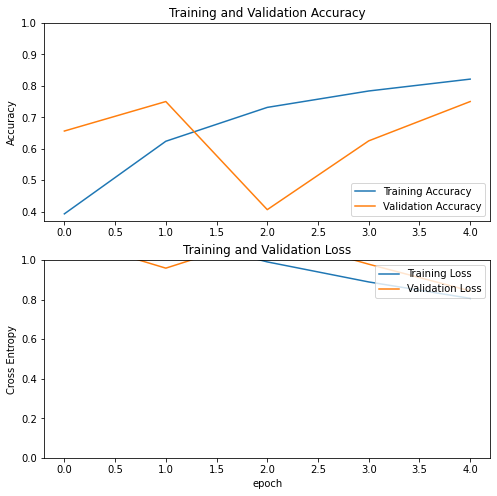

In [54]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [48]:
model_1.load_weights(checkpoint_filepath)

In [49]:
base_model.trainable = True

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:-20]:
  layer.trainable = False

In [50]:
for num, layer in enumerate(base_model.layers):
  print(num, layer.name, layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 tf.math.truediv_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [51]:
# Compile
base_learning_rate = 0.0001
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 4)                 5124      
                                                                 
Total params: 4,054,695
Trainable params: 1,356,084
Non-trainable params: 2,698,611
_________________________________________________________________


In [53]:
# Fitting our model for fine tuning 
fine_tune_epochs = initial_epochs + 5

history_fine_tune_model = model_1.fit(train_data, 
          epochs = fine_tune_epochs ,
          steps_per_epoch=len(train_data),
          validation_data = test_data , 
          validation_steps = len(test_data),
          initial_epoch =history_1.epoch[-1],
          callbacks=[model_checkpoint_callback]
          )

Epoch 5/10
29/29 [==============================] - ETA: 0s - loss: 0.3728 - accuracy: 0.9234
Epoch 5: saving model to weather_checkpoint/
29/29 [==============================] - 47s 2s/step - loss: 0.3728 - accuracy: 0.9234 - val_loss: 0.2327 - val_accuracy: 0.9241
Epoch 6/10
29/29 [==============================] - ETA: 0s - loss: 0.1017 - accuracy: 0.9711
Epoch 6: saving model to weather_checkpoint/
29/29 [==============================] - 43s 1s/step - loss: 0.1017 - accuracy: 0.9711 - val_loss: 0.1512 - val_accuracy: 0.9509
Epoch 7/10
29/29 [==============================] - ETA: 0s - loss: 0.0629 - accuracy: 0.9811
Epoch 7: saving model to weather_checkpoint/
29/29 [==============================] - 43s 1s/step - loss: 0.0629 - accuracy: 0.9811 - val_loss: 0.1089 - val_accuracy: 0.9643
Epoch 8/10
29/29 [==============================] - ETA: 0s - loss: 0.0433 - accuracy: 0.9867
Epoch 8: saving model to weather_checkpoint/
29/29 [==============================] - 43s 1s/step - lo

In [55]:
acc += history_fine_tune_model.history['accuracy']
val_acc += history_fine_tune_model.history['val_accuracy']

loss += history_fine_tune_model.history['loss']
val_loss += history_fine_tune_model.history['val_loss']

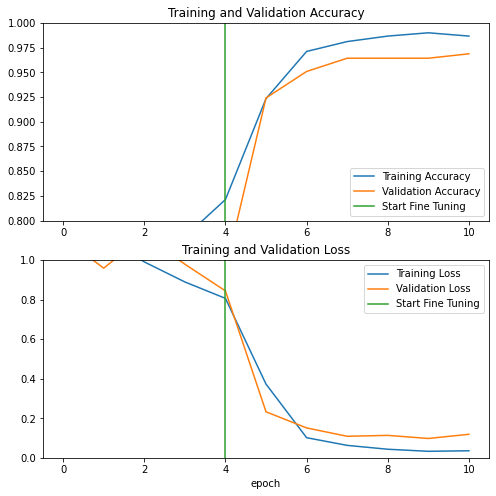

In [56]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [57]:
loss, accuracy = model_1.evaluate(test_data)
print('Test accuracy :', accuracy)

7/7 [==============================] - 8s 1s/step - loss: 0.1189 - accuracy: 0.9688
Test accuracy : 0.96875


In [62]:
import numpy as np

# Creating a function that would grab the image from a dataset, visualize and gives the prediction of it. 

def dataset_visualizer(dataset , model):
  '''
  Arguments: 
    dataset --> `tf.data.Dataset` object with (image , label) tuples 
    model --> the trained model 

  Returns: 
    Visualizae the image from the dataset and the prediction class of the image. 
  '''
  image_batch , label_batch = dataset.as_numpy_iterator().next() 
  batch_prob = [model.predict(tf.expand_dims(img , axis = 0)) for img in image_batch]
  batch_preds = [class_names[np.argmax(prob)] for prob in batch_prob]

  plt.figure(figsize= (10 , 10))
  for i in range(4):
    ax = plt.subplot(2 , 2 , i + 1)
    if class_names[np.argmax(label_batch[i])] == batch_preds[i]:
      title_color = 'g'
    else:
      title_color = 'r'
    plt.imshow(image_batch[i].astype('uint8'))
    plt.title(f"actual: {class_names[np.argmax(label_batch[i])]}, pred: {batch_preds[i]}, prob: {batch_prob[i].max():.2f}" , c = title_color)
    plt.axis('off')

1/1 [==============================] - 0s 54ms/step


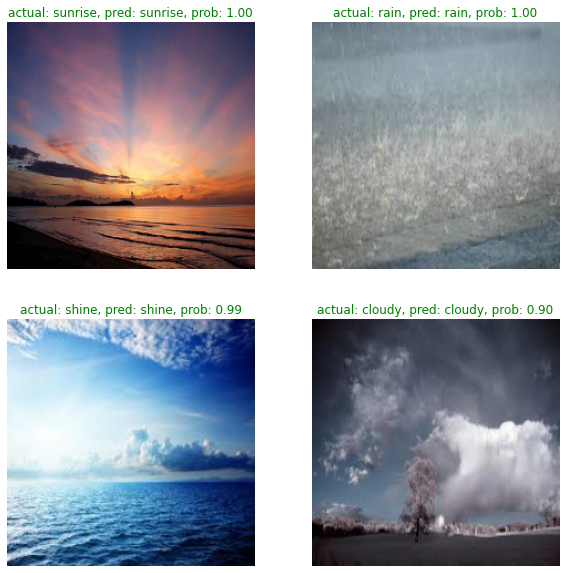

In [63]:
dataset_visualizer(test_data , model_1)

In [70]:
def predict_image(in_image, model):
  in_img = mpimg.imread(in_image)
  img_1 = tf.image.resize(in_img,(224,224))
  pred = model.predict(tf.expand_dims(img_1, axis=0)) 
  plt.imshow(in_img)
  plt.title(class_names[np.argmax(pred)])

1/1 [==============================] - 0s 53ms/step


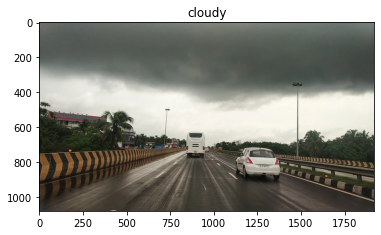

In [71]:
predict_image("cloudy.jpg", model_1)

1/1 [==============================] - 0s 52ms/step


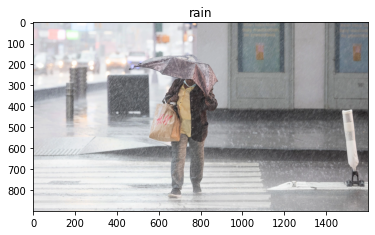

In [72]:
predict_image("rain_test.jpg", model_1)

1/1 [==============================] - 0s 55ms/step


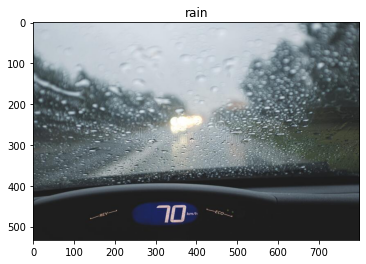

In [73]:
predict_image("rain_test_2.jpg", model_1)

1/1 [==============================] - 0s 58ms/step


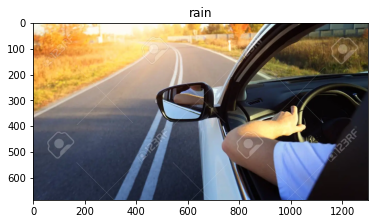

In [74]:
predict_image("sun.jpg", model_1)

1/1 [==============================] - 0s 53ms/step


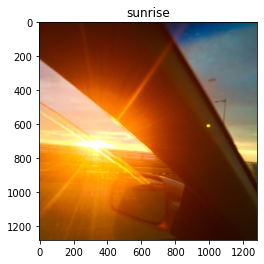

In [75]:
predict_image("sunrise.jpg", model_1)